In [1]:
!pip install numpy --upgrade --force-reinstall
!pip install --upgrade --force-reinstall transformers datasets scikit-learn boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.1 MB/s et

In [11]:
!pip install evaluate

  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)


In [1]:
# 📦 Step 1: Load environment variables from .env
from dotenv import load_dotenv
import os

load_dotenv()  # Loads variables from .env file

# 🔐 Step 2: Set up AWS session using environment variables
import boto3
import pandas as pd
from io import StringIO

aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
region = os.getenv("AWS_REGION")

session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=region
)
s3 = session.client('s3')

# 🪣 Step 3: Load CSV files from S3 using environment-provided keys
bucket = os.getenv("S3_BUCKET_NAME")
train_key = os.getenv("S3_TRAIN_KEY")
validation_key = os.getenv("S3_VALIDATION_KEY")
test_key = os.getenv("S3_TEST_KEY")

def load_csv_from_s3(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

train_df = load_csv_from_s3(bucket, train_key)
validation_df = load_csv_from_s3(bucket, validation_key)
test_df = load_csv_from_s3(bucket, test_key)


In [2]:
# Prepare the dataset using original_caption and fakenews_text
original_data = train_df[['original_caption', 'fakenews_text']].rename(
    columns={'original_caption': 'text', 'fakenews_text': 'label'}
)
# Drop any rows with missing values
original_data = original_data.dropna(subset=['text', 'label'])

print("Original Caption Data Sample:")
original_data.head()

Original Caption Data Sample:


,text,label
0,snowmobile in rainbow six siege,1
1,lines degrees of self,1
2,costa rica teams reaction after last penalty kick,0
3,these people in marvel themed wearable sleepin...,0
4,sad clown is sad give him a buck or two to che...,1


In [3]:
# Prepare the dataset using generated_caption and fakenews_text
generated_data = train_df[['generated_caption', 'fakenews_text']].rename(
    columns={'generated_caption': 'text', 'fakenews_text': 'label'}
)
# Drop any rows with missing values
generated_data = generated_data.dropna(subset=['text', 'label'])

print("Generated Caption Data Sample:")
generated_data.head()

Generated Caption Data Sample:


,text,label
1,a black and white photo of a wall with a shado...,1
3,dressed in costumes of different colors and sizes,0
4,a close up of a purse on a table with a lace d...,1
8,cars parked in front of a tall building on a c...,0
9,in a brown bag with a police officer on it,0


In [4]:
from transformers import AutoTokenizer

# Load the BERT tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenization function
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
from datasets import Dataset

# Convert to Hugging Face Dataset
#original_dataset = Dataset.from_pandas(original_data)
generated_dataset = Dataset.from_pandas(generated_data)

# Apply tokenizer
#original_tokenized = original_dataset.map(preprocess_function, batched=True)
generated_tokenized = generated_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/192936 [00:00<?, ? examples/s]

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
# Split original
#original_split = original_tokenized.train_test_split(test_size=0.2)
#original_full_train = original_split['train']
#original_eval = original_split['test']

#small_original_train = original_full_train.train_test_split(
    #test_size=0.80,            # discard 80 % of the train slice
   #seed=42
#)["train"]

#original_train = small_original_train

# Split generated
generated_split = generated_tokenized.train_test_split(test_size=0.2)
generated_full_train = generated_split['train']

small_generated_train = generated_full_train.train_test_split(
    test_size=0.80,          # discard 80 % of the train slice
    seed=42
)["train"]

generated_train = small_generated_train
generated_eval = generated_split['test']

In [10]:
from transformers import AutoModelForSequenceClassification

# Load BERT model for binary classification (2 labels: real = 0, fake = 1)
model_checkpoint = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/DeepfakeDetection/BERT_Text_Model/model_outputs",
    num_train_epochs=1,
    save_total_limit=1,
    load_best_model_at_end=True,
    eval_strategy="steps",                         # Evaluate at the end of each epoch
    save_strategy="steps",# Save at the end of each epoch
    save_steps=500,
    metric_for_best_model="accuracy",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=500,
    fp16=True
)



In [13]:
import numpy as np
from evaluate import load # Import load from evaluate

accuracy = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import Trainer

# Re-load the model to reset weights before each training
model_original = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

trainer_original = Trainer(
    model=model_original,
    args=training_args,
    train_dataset=original_train,
    eval_dataset=original_eval,
    compute_metrics=compute_metrics
)

# Train on original captions
print("🚀 Training on Original Captions...")
trainer_original.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training on Original Captions...


Epoch,Training Loss,Validation Loss


In [17]:
from transformers import Trainer

# Re-load the model again for generated captions (start fresh)
model_generated = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

trainer_generated = Trainer(
    model=model_generated,
    args=training_args,
    train_dataset=generated_train,
    eval_dataset=generated_eval,
    compute_metrics=compute_metrics
)

# Train on generated captions
print("🚀 Training on Generated Captions...")
trainer_generated.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


🚀 Training on Generated Captions...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tmbah1469 (tmbah1469-georgia-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
500,0.635200,0.605977,0.671504
1000,0.606300,0.605234,0.668628
1500,0.590500,0.586984,0.691614


TrainOutput(global_step=1930, training_loss=0.6036303110073268, metrics={'train_runtime': 1781.3784, 'train_samples_per_second': 17.329, 'train_steps_per_second': 1.083, 'total_flos': 8121975167907840.0, 'train_loss': 0.6036303110073268, 'epoch': 1.0})

In [18]:
# 🚀 Save generated caption model locally first
trainer_generated.save_model("bert-generated-caption-model")

# 🚀 Now move (upload) it to Google Drive
import shutil

# Define your Google Drive destination
drive_destination = "/content/drive/MyDrive/DeepfakeDetection/BERT_Text_Model/bert-generated-caption-model"

# Move the folder
shutil.move("bert-generated-caption-model", drive_destination)

print(f"✅ Model saved successfully to {drive_destination}")


✅ Model saved successfully to /content/drive/MyDrive/DeepfakeDetection/BERT_Text_Model/bert-generated-caption-model


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Run predictions on the evaluation dataset (Original or Generated)
predictions_output = trainer_generated.predict(generated_eval)
y_true = predictions_output.label_ids
y_pred = np.argmax(predictions_output.predictions, axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

        Real       0.68      0.85      0.75     21565
        Fake       0.72      0.49      0.59     17023

    accuracy                           0.69     38588
   macro avg       0.70      0.67      0.67     38588
weighted avg       0.70      0.69      0.68     38588

Confusion Matrix:
 [[18263  3302]
 [ 8598  8425]]


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate Original Caption Model
#original_predictions = trainer_original.predict(original_eval)
#y_true_original = original_predictions.label_ids
#y_pred_original = np.argmax(original_predictions.predictions, axis=1)

# Evaluate Generated Caption Model
generated_predictions = trainer_generated.predict(generated_eval)
y_true_generated = generated_predictions.label_ids
y_pred_generated = np.argmax(generated_predictions.predictions, axis=1)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



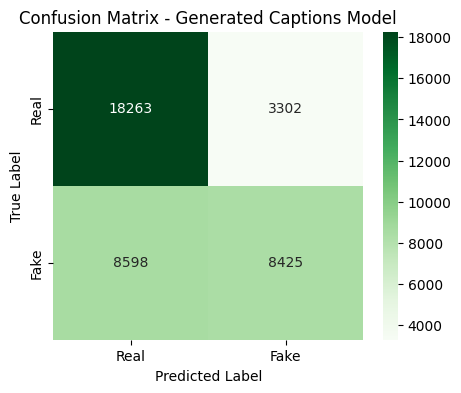

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use existing predictions
cm_generated = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_generated,
    annot=True,
    fmt='d',
    cmap='Greens',                       # or any color map you like
    xticklabels=['Real', 'Fake'],         # ✅ consistent with your classification_report labels
    yticklabels=['Real', 'Fake']
)
plt.title("Confusion Matrix - Generated Captions Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



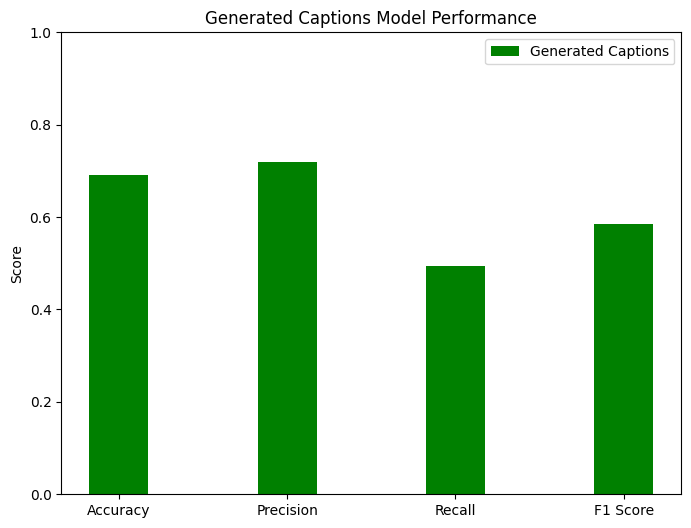

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Metrics for Generated Model
accuracy_generated = accuracy_score(y_true, y_pred)
precision_generated = precision_score(y_true, y_pred)
recall_generated = recall_score(y_true, y_pred)
f1_generated = f1_score(y_true, y_pred)

# Visualization
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
generated_scores = [accuracy_generated, precision_generated, recall_generated, f1_generated]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects = ax.bar(x, generated_scores, width, label='Generated Captions', color='green')

ax.set_ylabel('Score')
ax.set_title('Generated Captions Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim(0, 1)
plt.show()
